# Fitting BRT and making a map

In [8]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# data input
data = pd.read_csv("../../data/cal_habs_filled_chl_sst_rrs_all_stations.csv")
# summing the two Pseudo-nitzschia species
data["Pn_total"] = data["Pn_delicatissima"].add(data["Pn_seriata"], fill_value=0)
data[["Pn_delicatissima", "Pn_seriata", "Pn_total"]]
#print(data["Pn_total"].to_list())

,Pn_delicatissima,Pn_seriata,Pn_total
0,NaN,1600.000,1600.0000
1,28080.0000,35320.000,63400.0000
2,1599.2302,9595.381,11194.6112
3,1252.0000,0.000,1252.0000
4,6358.0000,1122.000,7480.0000
...,...,...,...
649,1496.0000,0.000,1496.0000
650,NaN,NaN,NaN
651,NaN,NaN,NaN
652,38381.5230,2132.307,40513.8300


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
rrs_cols = [c for c in data.columns
            if c.startswith("Rrs_") and c[-1].isdigit()]
rrs_cols

# Sorry nothing except plain wavelengths in code below
#ENV_VARS = ["sst"] # , "chlor_a"
#ENV_VARS = ["Temp", "Avg_Chloro"]

data2 = data[data["Pn_total"].notna()].copy() #Create copy of data by keeping only rows of data where Np_total has a value (non-NA).

# Create a new column in df for the ratio
wavelength1 = "Rrs_530.0"
wavelength2 = "Rrs_532.0"
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
data2[Rrs_ratio] = (data2[wavelength1] - data2[wavelength2]) / (data2[wavelength1] + data2[wavelength2])

In [11]:
# Model 1 a bunch of Rrs
predictors = [
    # Blue (chlorophyll absorption)
    "Rrs_440.0",
    "Rrs_445.0",
    "Rrs_470.0",
    "Rrs_490.0",

    # Blue–green transition
    "Rrs_510.0",
    "Rrs_530.0",

    # Green (biomass / reference)
    "Rrs_545.0",
    "Rrs_555.0",

    # Yellow–red
    "Rrs_615.0",
    "Rrs_630.0",

    # Red chlorophyll absorption
    "Rrs_665.0",
    "Rrs_678.0",

    # Red edge / fluorescence
    "Rrs_701.0",
    "Rrs_703.0",
    "Rrs_709.0",
]

In [12]:
# Set up X and y
X = data2[predictors]
y = np.log10(data2["Pn_total"])
# Get rid of NaNs, BRT gets mad otherwise (Keep only the rows where every column in X is non-NA and non-Inf, and apply the exact same row filtering to y.)
mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y)
X = X.loc[mask].copy()
y = y.loc[mask].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

brt1 = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18) # change random_state for a new random train set
brt1.fit(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [21]:
# Make a function to compare test and train fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_train_test_predictions(
    model, X_train, y_train, X_test, y_test, model_name="Model"
):
    """
    Side-by-side scatter plots of observed vs predicted for
    train and test data, with Pearson r and R² in titles.
    """

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    r_train  = np.corrcoef(y_train, y_pred_train)[0, 1]
    r2_train = r2_score(y_train, y_pred_train)

    r_test  = np.corrcoef(y_test, y_pred_test)[0, 1]
    r2_test = r2_score(y_test, y_pred_test)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    # Train
    axes[0].scatter(y_train, y_pred_train, alpha=0.5)
    axes[0].set_title(
        f"{model_name} – Train\nr = {r_train:.3f}, R² = {r2_train:.3f}"
    )
    axes[0].set_xlabel("Observed")
    axes[0].set_ylabel("Predicted")

    # Test
    axes[1].scatter(y_test, y_pred_test, alpha=0.5)
    axes[1].set_title(
        f"{model_name} – Test\nr = {r_test:.3f}, R² = {r2_test:.3f}"
    )
    axes[1].set_xlabel("Observed")

    plt.tight_layout()
    plt.show()

    # Also return metrics if you want them later
    return {
        "train": {"r": r_train, "r2": r2_train},
        "test":  {"r": r_test,  "r2": r2_test},
    }


## Classic overfitting

The model fits the training data well but shows little skill on held-out data, indicating overfitting and limited generalizable signal in the predictors. This likely reflects a combination of model flexibility, high predictor dimensionality, and the indirect relationship between Rrs and Pseudo-nitzschia abundance.

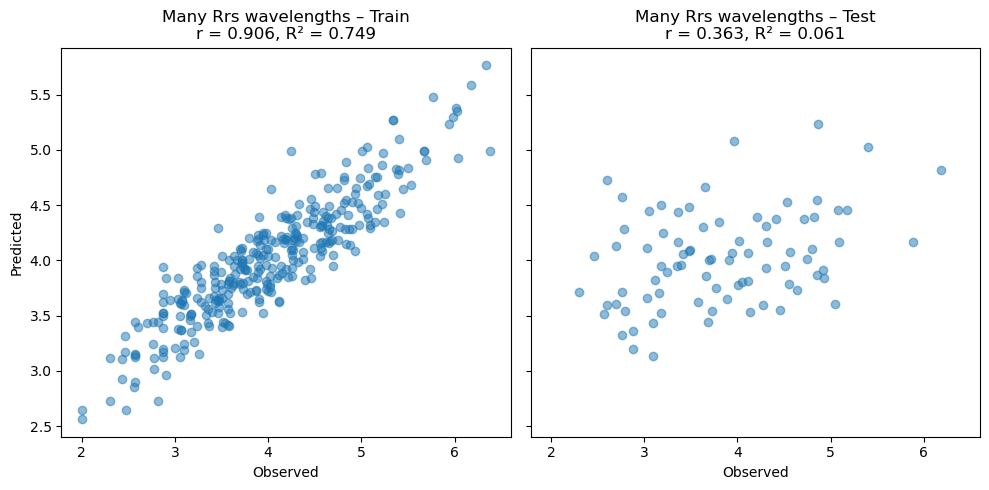

In [23]:
plot_train_test_predictions(
    brt1, X_train, y_train, X_test, y_test, model_name="Many Rrs wavelengths"
);

### Better with one ratio

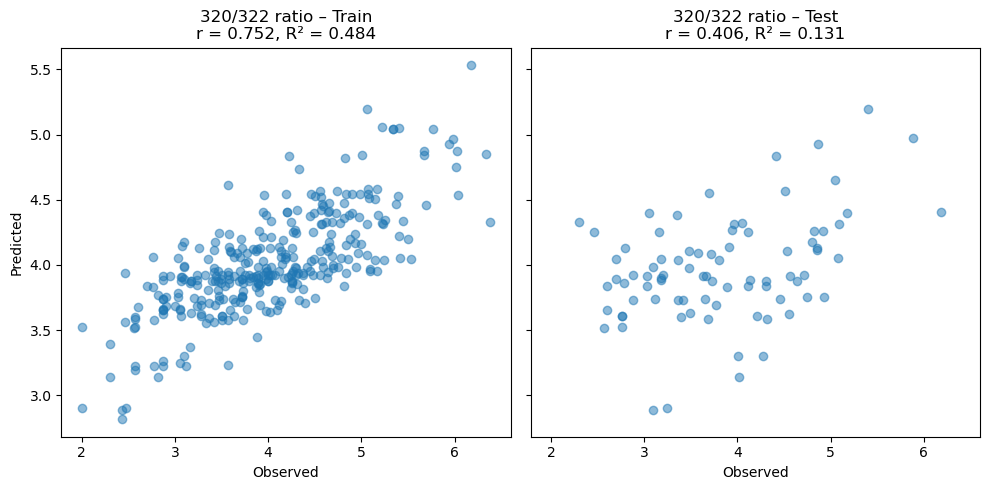

In [27]:
plot_train_test_predictions(
    brt2, X2_train, y_train, X2_test, y_test, model_name="320/322 ratio"
);

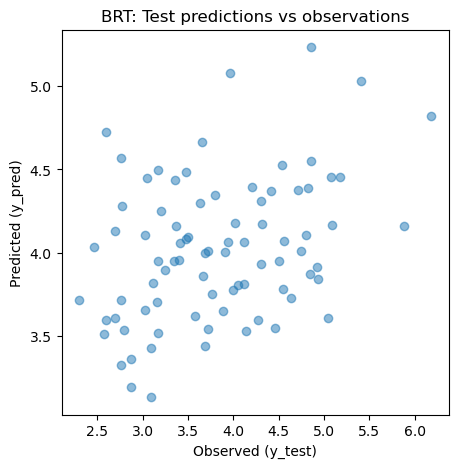

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Observed (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.title("BRT: Test predictions vs observations")
plt.show()

In [122]:
# See how well it fits the training data
y_pred = brt1.predict(X_train) #predictions

r = np.corrcoef(y_train, y_pred)[0, 1]
r2 = r2_score(y_train, y_pred)

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")

BRT Pearson r : 0.906
BRT R²        : 0.749


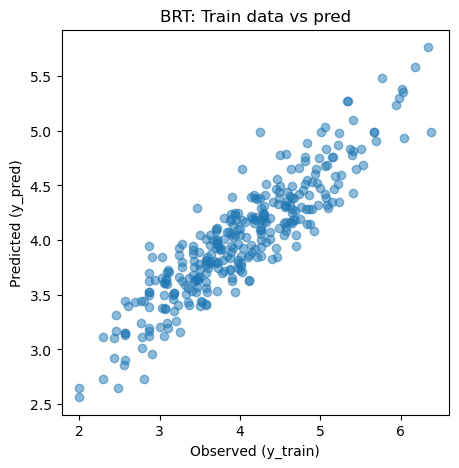

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.xlabel("Observed (y_train)")
plt.ylabel("Predicted (y_pred)")
plt.title("BRT: Train data vs pred")
plt.show()

## Try a model just with a ratio

In [14]:
# Model 2 just the ratio
predictors2 = [Rrs_ratio]
# Set up X and y
X2 = data2[predictors2]
X2 = X2.loc[mask].copy()
# Keep seed the same so don't need to change y
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=18)
# Fit model
brt2 = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18) # change random_state for a new random train set
brt2.fit(X2_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [136]:
# This one is better
y_pred = brt2.predict(X2_test) #predictions of held out data
r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)
print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")

BRT Pearson r : 0.406
BRT R²        : 0.131


## Make prediction map

Get some PACE data and make a prediction using Rrs (and only Rrs).

In [1]:
# Function 1 takes a xarray dataset from PACE with Rrs and makes into data frame
import xarray as xr
def make_prediction(R: xr.Dataset, brt_model, feature_cols):
    # --- 3. Stack lat/lon into a single "pixel" dimension ---
    R2 = R.stack(pixel=("lat", "lon"))  # (pixel, wavelength)
    R2 = R2.transpose("pixel", "wavelength")
    # Load this subset into memory
    R2_vals = R2.values  # shape: (n_pixel, n_wavelength)

    # --- 4. Make predictions dataframe
    df_pred = pd.DataFrame(R2_vals, columns=feature_cols)

    # --- 5. Handle NaNs: BRTs generally cannot handle NaNs in predictors ---
    # Rrs dataset will have loads of NaNs
    valid_mask = ~df_pred.isna().any(axis=1)  # pixels with all bands present
    df_valid = df_pred[valid_mask]

    # Prepare an array for predictions (fill NaNs where we cannot predict)
    y_pred_flat = np.full(df_pred.shape[0], np.nan, dtype=float)

    # --- 6. Predict on the valid pixels ---
    if len(df_valid) > 0:
        y_pred_flat[valid_mask.values] = brt_model.predict(df_valid)

    # --- 7. Reshape back to (lat, lon) ---
    nlat = R.sizes["lat"]
    nlon = R.sizes["lon"]
    pred_map = y_pred_flat.reshape(nlat, nlon)

    pred_da = xr.DataArray(
        pred_map,
        coords={"lat": R["lat"], "lon": R["lon"]},
        dims=("lat", "lon"),
        name="y_pred"
    )

    return pred_da

In [2]:
# Function 2 make a map
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def make_brt_plot(
    brt_da: xr.DataArray,
    label: str = "BRT prediction",
    cmap: str = "viridis",
):
    """Plot a single-panel BRT prediction map (lat/lon grid)."""

    # limits from prediction only
    vals = brt_da.values.ravel()
    vmin, vmax = np.nanpercentile(vals, (0, 100))

    fig, ax = plt.subplots(
        1, 1,
        figsize=(6, 4),
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True,
    )

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    im = ax.pcolormesh(
        brt_da["lon"],
        brt_da["lat"],
        brt_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap,
    )

    ax.set_title(label)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.06, pad=0.08)
    cbar.set_label(label)

    plt.show()


In [3]:
import numpy as np
import xarray as xr

def build_R_sel(R: xr.DataArray, feature_cols, eps=1e-12) -> xr.DataArray:
    """
    Return a DataArray with dims (lat, lon, wavelength) where the 'wavelength'
    coordinate contains the model feature names in feature_cols order.

    Works when feature_cols are all 'Rrs_...' OR all 'ndi_...'.
    """
    cols = list(feature_cols)

    # --------
    # Case 1: plain Rrs bands
    # --------
    if all(c.startswith("Rrs_") for c in cols):
        wls = [float(c.split("Rrs_")[1]) for c in cols]
        arrs = [R.sel(wavelength=wl) for wl in wls]          # (lat, lon)
        R_sel = xr.concat(arrs, dim="wavelength")            # now (lat, lon, wavelength)
        R_sel = R_sel.assign_coords(wavelength=cols)         # rename coord values to feature names
        return R_sel

    # --------
    # Case 2: NDI ratios
    # --------
    if all(c.startswith("ndi_") for c in cols):
        # gather all band wavelengths needed
        needed = sorted({
            float(part.rstrip("_"))
            for c in cols
            for part in c.split("Rrs_")[1:]                  # e.g. ['530.0_', '532.0']
        })
        R_sub = R.sel(wavelength=np.array(needed))

        arrs = []
        for name in cols:
            # name like 'ndi_Rrs_530.0_Rrs_532.0'
            p1, p2 = [p.rstrip("_") for p in name.split("Rrs_")[1:]]  # ['530.0', '532.0']
            wl1, wl2 = float(p1), float(p2)

            a = R_sub.sel(wavelength=wl1)
            b = R_sub.sel(wavelength=wl2)
            arrs.append((a - b) / (a + b + eps))             # (lat, lon)

        R_sel = xr.concat(arrs, dim="wavelength")            # (lat, lon, wavelength)
        R_sel = R_sel.assign_coords(wavelength=cols)         # coordinate values are feature names
        return R_sel

    raise ValueError("feature_cols must be all 'Rrs_' or all 'ndi_' (not mixed).")


### Get the PACE Rrs map

We will look at July 29, 2024 when a bloom was occurring per C-HARM.

![](https://coastwatch.pfeg.noaa.gov/wcn/erddap/griddap/wvcharmV4_0day.png?pseudo_nitzschia%5B(2024-07-29T12:00:00Z)%5D%5B(31.3):(43.0)%5D%5B(232.5):(243.0)%5D&.draw=surface&.vars=longitude%7Clatitude%7Cpseudo_nitzschia&.colorBar=%7C%7C%7C%7C%7C&.bgColor=0xffccccff)

In [20]:
import earthaccess
import xarray as xr

day = "2024-07-29"

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

## Select a small region to make a prediction

In [17]:
# California Bloom
# Set a box
lat_min, lat_max = 32, 42
lon_min, lon_max = -125, -117
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
R = R.transpose("lat", "lon", "wavelength")

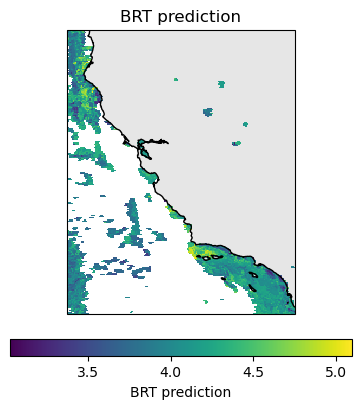

CPU times: user 1.01 s, sys: 246 ms, total: 1.25 s
Wall time: 5.09 s


In [18]:
%%time
# Make prediction with model 1
feature_cols = list(X_train.columns) # predictors
# This makes a R_sel with the predictors; deals with ndi_ratio
R_sel = build_R_sel(R, feature_cols)
pred_da = make_prediction(R_sel, brt1, feature_cols)
# Make a plot
make_brt_plot(pred_da)

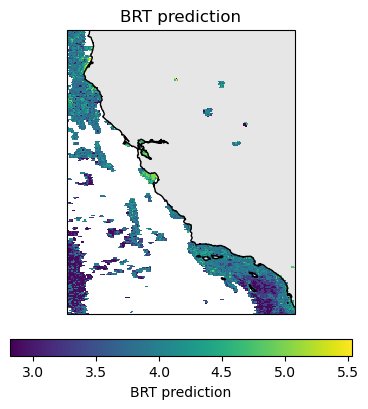

CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 316 ms


In [19]:
%%time
# Make prediction with model 2 with ratio only
feature_cols = list(X2_train.columns) # predictors
# This makes a R_sel with the predictors; deals with ndi_ratio
R_sel = build_R_sel(R, feature_cols)
pred_da = make_prediction(R_sel, brt2, feature_cols)
# Make a plot
make_brt_plot(pred_da)

## Compare to a day with no bloom

January 25, 2025

![](https://coastwatch.pfeg.noaa.gov/wcn/erddap/griddap/wvcharmV4_0day.png?pseudo_nitzschia%5B(2025-06-03T12:00:00Z)%5D%5B(31.3):(43.0)%5D%5B(232.5):(243.0)%5D&.draw=surface&.vars=longitude%7Clatitude%7Cpseudo_nitzschia&.colorBar=%7C%7C%7C%7C%7C&.bgColor=0xffccccff)